In [1]:
# Load model directly
from transformers import NougatProcessor, VisionEncoderDecoderModel
import torch

processor = NougatProcessor.from_pretrained('facebook/nougat-small')
model = VisionEncoderDecoderModel.from_pretrained('facebook/nougat-small')

Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    896,
    672
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "qkv_bias": true,
  "transformers_version": "4.46.0",
  "use_absolute_embeddings": false,
  "window_size": 7
}

Config of the decoder: <class 'transformers.models.mbart.modeling_mbart.MBartForCausalLM'> is overwritten by shared decoder config: MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "add_final_layer_norm": true

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           

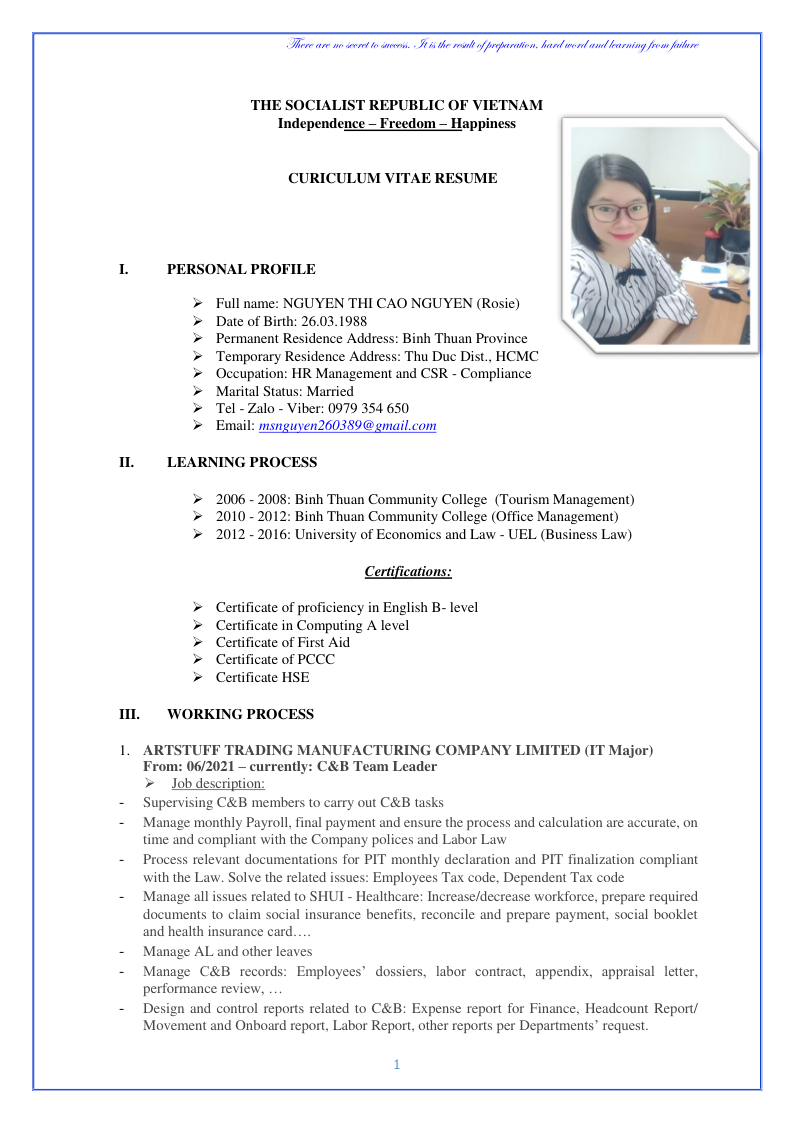

In [3]:
from typing import Optional, List
import io
import fitz
from pathlib import Path

def rasterize_paper(
    pdf: Path,
    outpath: Optional[Path] = None,
    dpi: int = 96,
    return_pil=False,
    pages=None,
) -> Optional[List[io.BytesIO]]:
    """
    Rasterize a PDF file to PNG images.

    Args:
        pdf (Path): The path to the PDF file.
        outpath (Optional[Path], optional): The output directory. If None, the PIL images will be returned instead. Defaults to None.
        dpi (int, optional): The output DPI. Defaults to 96.
        return_pil (bool, optional): Whether to return the PIL images instead of writing them to disk. Defaults to False.
        pages (Optional[List[int]], optional): The pages to rasterize. If None, all pages will be rasterized. Defaults to None.

    Returns:
        Optional[List[io.BytesIO]]: The PIL images if `return_pil` is True, otherwise None.
    """

    pillow_images = []
    if outpath is None:
        return_pil = True
    try:
        if isinstance(pdf, (str, Path)):
            pdf = fitz.open(pdf)
        if pages is None:
            pages = range(len(pdf))
        for i in pages:
            page_bytes: bytes = pdf[i].get_pixmap(dpi=dpi).pil_tobytes(format="PNG")
            if return_pil:
                pillow_images.append(io.BytesIO(page_bytes))
            else:
                with (outpath / ("%02d.png" % (i + 1))).open("wb") as f:
                    f.write(page_bytes)
    except Exception:
        pass
    if return_pil:
        return pillow_images
     

from PIL import Image

images = rasterize_paper(pdf="pdf\\NGUYEN THI CAO NGUYEN - HCNS.pdf", return_pil=True)
image = Image.open(images[0])
image

In [11]:
# prepare image for the model
pixel_values = processor(images=image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 896, 672])


In [7]:
from transformers import StoppingCriteria, StoppingCriteriaList
from collections import defaultdict

class RunningVarTorch:
    def __init__(self, L=15, norm=False):
        self.values = None
        self.L = L
        self.norm = norm

    def push(self, x: torch.Tensor):
        assert x.dim() == 1
        if self.values is None:
            self.values = x[:, None]
        elif self.values.shape[1] < self.L:
            self.values = torch.cat((self.values, x[:, None]), 1)
        else:
            self.values = torch.cat((self.values[:, 1:], x[:, None]), 1)

    def variance(self):
        if self.values is None:
            return
        if self.norm:
            return torch.var(self.values, 1) / self.values.shape[1]
        else:
            return torch.var(self.values, 1)

class StoppingCriteriaScores(StoppingCriteria):
    def __init__(self, threshold: float = 0.015, window_size: int = 200):
        super().__init__()
        self.threshold = threshold
        self.vars = RunningVarTorch(norm=True)
        self.varvars = RunningVarTorch(L=window_size)
        self.stop_inds = defaultdict(int)
        self.stopped = defaultdict(bool)
        self.size = 0
        self.window_size = window_size

    @torch.no_grad()
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_scores = scores[-1]
        self.vars.push(last_scores.max(1)[0].float().cpu())
        self.varvars.push(self.vars.variance())
        self.size += 1
        if self.size < self.window_size:
            return False

        varvar = self.varvars.variance()
        for b in range(len(last_scores)):
            if varvar[b] < self.threshold:
                if self.stop_inds[b] > 0 and not self.stopped[b]:
                    self.stopped[b] = self.stop_inds[b] >= self.size
                else:
                    self.stop_inds[b] = int(
                        min(max(self.size, 1) * 1.15 + 150 + self.window_size, 4095)
                    )
            else:
                self.stop_inds[b] = 0
                self.stopped[b] = False
        return all(self.stopped.values()) and len(self.stopped) > 0

In [12]:
outputs = model.generate(pixel_values.to(device),
                          min_length=1,
                          max_length=10000,
                          bad_words_ids=[[processor.tokenizer.unk_token_id]],
                          return_dict_in_generate=True,
                          output_scores=True,
                          stopping_criteria=StoppingCriteriaList([StoppingCriteriaScores()]),
)

C:\Users\Seyren\AppData\Local\Temp\ipykernel_38748\280645719.py:23: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  return torch.var(self.values, 1) / self.values.shape[1]


In [13]:

images = rasterize_paper(pdf="pdf\\NGUYEN THI CAO NGUYEN - HCNS.pdf", return_pil=True)

generated = processor.batch_decode(outputs[0], skip_special_tokens=True)[0]
generated = processor.post_process_generation(generated, fix_markdown=False)
print(generated)

_More are an event to access. It is the read of/performation, stored and/testing from/date_

**THE SOCIALIST REPUBLIC OF VIETNAM**

**Independence - Freedom - Happiness**

**CURRICULUM VITAE RESUME**

**I. PERSONAL PROFILE**

\(\succ\) **Full name: NGUYEN THI CAO NGUYEN (Rosie)**

\(\succ\) **Date of Birth: 26.03.1988**

\(\succ\) **Permanent Residence Address: Binh Thuan Province**

\(\succ\) **Temporary Residence Address: Thu Duc Dist., HCMC**

\(\succ\) **Occupation: HR Management and CSR - Compliance**

\(\succ\) **Marital Status: Married**

\(\succ\) **Tel - Zalo - Viber: 0979 354 650**

\(\succ\) **Email:** _msuguven260389@gmail.com_

**II. LEARNING PROCESS**

\(\succ\) **2006 - 2008: Binh Thuan Community College (Tourism Management)**

\(\succ\) **2010 - 2012: Binh Thuan Community College (Office Management)**

\(\succ\) **2012 - 2016: University of Economics and Law - UEL (Business Law)**

_Certifications:_

\(\succ\) **Certificate of proficiency in English B- level**

\(\succ\

In [29]:
from PIL import Image
from surya.ocr import run_ocr
from surya.model.detection.model import load_model as load_det_model, load_processor as load_det_processor
from surya.model.recognition.model import load_model as load_rec_model
from surya.model.recognition.processor import load_processor as load_rec_processor

images = rasterize_paper(pdf="pdf\\NGUYEN HOANG TRƯỜNG GIANG - HCNS.pdf", return_pil=True)

image = Image.open(images[3])
langs = ["en", "vi"] # Replace with your languages - optional but recommended
det_processor, det_model = load_det_processor(), load_det_model()
rec_model, rec_processor = load_rec_model(), load_rec_processor()

predictions = run_ocr([image], [langs], det_model, det_processor, rec_model, rec_processor)

Loaded detection model vikp/surya_det3 on device cuda with dtype torch.float16
Loaded recognition model vikp/surya_rec2 on device cuda with dtype torch.float16


Recognizing Text: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


In [30]:
textlines = []

for prediction in predictions:
    for textline in prediction.text_lines:
        result_dict = {}
        result_dict['text'] = textline.text
        
        x1, y1 = textline.bbox[0], textline.bbox[1]
        x2, y2 = textline.bbox[2], textline.bbox[3]
        bbox_w = abs(x1 - x2)
        bbox_h = abs(y1 - y2)
        
        # result_dict['top_left_corner'] = []
        # result_dict['top_left_corner'].append(textline.bbox[0])
        # result_dict['top_left_corner'].append(textline.bbox[1])
        
        # result_dict['bottom_right_corner'] = []
        # result_dict['bottom_right_corner'].append(textline.bbox[2])
        # result_dict['bottom_right_corner'].append(textline.bbox[3])
        
        # textlines.append(result_dict)
        result_dict['bbox_area'] = []
        result_dict['bbox_area'].append(bbox_w)
        result_dict['bbox_area'].append(bbox_h)
        textlines.append(result_dict)
        
for textline in textlines:
    print(textline)
    print()

{'text': '√', 'bbox_area': [14.0, 15.0]}

{'text': 'Supplying', 'bbox_area': [68.0, 15.0]}

{'text': '√', 'bbox_area': [13.0, 15.0]}

{'text': 'English translation', 'bbox_area': [124.0, 15.0]}

{'text': 'Results:', 'bbox_area': [88.0, 22.0]}

{'text': '√', 'bbox_area': [14.0, 14.0]}

{'text': 'Formed the HR department', 'bbox_area': [179.0, 15.0]}

{'text': '√', 'bbox_area': [14.0, 13.0]}

{'text': 'Register procedures for the forming of company', 'bbox_area': [313.0, 15.0]}

{'text': 'v', 'bbox_area': [13.0, 14.0]}

{'text': 'Issued the company rules, the wage schedule, bonus, etc.', 'bbox_area': [367.0, 14.0]}

{'text': 'Hung Thái Textile & Garment Ltd. - Tây Ninh Province | 07/2010 - 08/2012', 'bbox_area': [510.0, 18.0]}

{'text': 'C.E.O Assistant and HR Manager', 'bbox_area': [364.0, 23.0]}

{'text': '>', 'bbox_area': [14.0, 13.0]}

{'text': 'Managing all HR works', 'bbox_area': [157.0, 15.0]}

{'text': '√', 'bbox_area': [14.0, 13.0]}

{'text': 'Control the production issues', 'bb